## Image tag parsing and annotation preview
Version 2021-01-04

### Load libraries

In [1]:
from cv2 import cv2
import os
import json
import pathlib
import torch
from torch.utils.data import DataLoader


## Select data location

Set *root_dir* to point to "Supervisely" project folder

In [7]:
#Set path to root dir (wrist folder)
root_dir = pathlib.Path('../literature/Other/supervisely')

# Path to annotation dir
ann_dir = pathlib.Path(root_dir, 'wrist/ann')

# Path to image dir
img_dir = pathlib.Path(root_dir, 'wrist/img')

# Lists
list_files = lambda start_dir: [str(item) for item in start_dir.iterdir()]
ann_list = list_files(ann_dir)
img_list = list_files(img_dir)
print('Number of annotations: {}'.format(len(ann_list)))

Number of annotations: 15327


In [3]:
print("The working directory of this project is:", os.getcwd())
print("The root dir selected is:", root_dir)
print("The annotation dir selected is:", ann_dir)
print("The image dir selected is:", img_dir)


The working directory of this project is: c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu\notebooks
The root dir selected is: ..\literature\Other\supervisely
The annotation dir selected is: ..\literature\Other\supervisely\wrist\ann
The image dir selected is: ..\literature\Other\supervisely\wrist\img


## Functions used to parse and preview data 

In [8]:
# Function that is parsing json file and printing all usefull data
def parse_json(path_to_annotation):
    #Load data
    with open(path_to_annotation) as json_file:  
        # Load json
        data = json.load(json_file)
        
        # Print tags:
        print('Tags:')
        for tag in data['tags']:
            print(tag)
            
        print('*******************')
        print('Objects:')
        #Print objects:
        for object_dict in data['objects']:
            print('Object type: {}\nObject points: {}'.format(object_dict['classTitle'], 
                                                                   object_dict['points']['exterior']))
            print('*******************')    
            

def display_annotations(path_to_annotation, image_dir, objectname, scale = 1):
    #Load data
    with open(path_to_annotation) as json_file:
        
        # Get name of the file
        name = pathlib.PurePath(path_to_annotation).name.split('.')[0]
        image = image_dir / (str(name) + '.png')

        # Load image
        original_image = cv2.imread(str(image))
        original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
        annotated_image = original_image.copy()
        
        # Load json
        data = json.load(json_file)
        
        # Draw fractures
        for object_dict in data['objects']:
            # Check if object is fracture
            if object_dict['classTitle'] == objectname:
               
                # Get points and convert them to int for display purposes
                top_left_point, bottom_right_point = object_dict['points']['exterior']
                top_left_point = list(map(int,top_left_point))
                bottom_right_point = list(map(int, bottom_right_point))
                
                # Draw points
                cv2.rectangle(annotated_image, (top_left_point[0], top_left_point[1]), 
                              (bottom_right_point[0], bottom_right_point[1]), (0, 0, 255), 5)
        
        # Scale images for display purposes
        original_image = cv2.resize(original_image, (0,0), fx=scale, fy=scale) 
        annotated_image = cv2.resize(annotated_image, (0,0), fx=scale, fy=scale) 
        
        # Display images
        cv2.imshow('Original', original_image)
        cv2.imshow('Annotated', annotated_image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

## Main function

Select index name of the image/object that you want to preview.

In [16]:
# Select index of the image to preview
index = 53
objectname = 'fracture'

# To close images press any key
parse_json(ann_list[index])

Tags:
{'name': 'ao_classification', 'value': '23-M/3.1'}
cast
projection_ap
side_right
*******************
Objects:
Object type: text
Object points: [[613.0, 335.0], [706.0, 455.0]]
*******************
Object type: fracture
Object points: [[229.48664474487305, 630.7427520751953], [330.1251106262207, 710.4746551513672]]
*******************
Object type: fracture
Object points: [[348.0, 746.0], [429.0, 825.0]]
*******************
Object type: axis
Object points: [[306.0, 856.0], [488.0, 30.0]]
*******************


In [17]:
display_annotations(ann_list[index], img_dir, objectname, scale = 0.75)

Fix annotations containing only fracture boxes and labes


In [57]:
#this function returns the label and annotation for each instance
def get_targets(path_to_annotation):
    #Load data
    targets = []
    with open(path_to_annotation) as json_file:  
        # Load json
        data = json.load(json_file)
        d = {}
        
        for object_dict in data['objects']:
            # Check if object contains any fractures 

            box = []

            if object_dict['classTitle'] == "fracture":
                # Get points and convert them to int for display purposes
                top_left_point, bottom_right_point = object_dict['points']['exterior']
                top_left_point = list(map(int,top_left_point))
                bottom_right_point = list(map(int, bottom_right_point))
                box = (top_left_point+bottom_right_point)
                d['boxes'] = torch.FloatTensor(box)
                d['labels'] = "fracture"
                targets.append(d)
        
        if not d:
            d['labels'] = "no_fracture"
            d['boxes'] =  torch.zeros(4)
            targets.append(d)

    return targets
            

In [61]:
get_targets(ann_list[5])

[{'boxes': tensor([213., 627., 288., 715.]), 'labels': 'fracture'},
 {'boxes': tensor([213., 627., 288., 715.]), 'labels': 'fracture'}]

In [2]:

import os
print(os.getcwd())    

c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu\notebooks


In [2]:
import sys
sys.path.append('../')

from src.data.my_dataset import XRayDataSet

In [3]:
dataset = XRayDataSet(pathlib.Path('../literature/Other/supervisely/wrist'))

In [6]:
training_dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=4)

In [9]:
images , targets = next(iter(training_dataloader))

In [20]:
images[0]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [14]:
import matplotlib.pyplot as plt

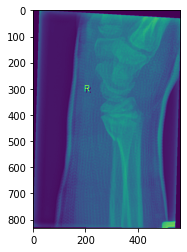

In [22]:
plt.imshow(images[0].permute(1, 2, 0))